# Fujitsu IP Analytics
## Project: Backorders prediction

This project analyses the data from a distributor.

## Getting Started
Loading the dataset

In [50]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from time import time
import scipy
import matplotlib.patches as mpatches
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
import helper as hp
# Pretty display for notebooks
%matplotlib inline
print "Libraries imported successfully"

Libraries imported successfully


In [57]:
# Load the backorders training dataset
try:
    data = pd.read_csv('backorderTrain.csv',header =0)
    print "backorders dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

backorders dataset has 1693050 samples with 23 features each.


## Data Exploration
the author of the database labelled with 1 no exoplanet system and 2 exoplanet system

In [58]:
#create label array and drop it from features
labels = data.went_on_backorder
labels.replace('No',0, inplace=True)
labels.replace('Yes',1, inplace=True)
data.fillna(0,inplace =True)
data.drop(['sku','went_on_backorder'],axis=1, inplace =True)
for col in ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk','stop_auto_buy', 'rev_stop']:
        data[col] = (data[col] == 'Yes').astype(int)

In [59]:
# Display a description of the dataset
display(data.describe())

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
count,1.693050e+06,1.693050e+06,1.693050e+06,1.693050e+06,1.693050e+06,1.693050e+06,1.693050e+06,1.693050e+06,1.693050e+06,1.693050e+06,...,1.693050e+06,1.693050e+06,1.693050e+06,1.693050e+06,1.693050e+06,1.693050e+06,1.693050e+06,1.693050e+06,1.693050e+06,1.693050e+06
mean,4.940574e+02,7.435329e+00,4.031745e+01,1.816772e+02,3.431218e+02,5.018450e+02,5.365595e+01,1.735685e+02,3.407958e+02,5.120291e+02,...,4.801985e-04,1.737455e+00,-6.891604e+00,-6.437676e+00,6.507197e-01,2.039461e-01,1.807389e-04,1.190000e-01,9.611866e-01,4.193615e-04
std,2.922938e+04,7.079617e+00,1.066337e+03,5.458868e+03,9.703406e+03,1.382572e+04,1.689275e+03,5.151446e+03,9.399142e+03,1.399001e+04,...,2.190818e-02,2.615318e+02,2.657089e+01,2.583929e+01,4.215168e+01,4.029295e-01,1.344271e-02,3.237886e-01,1.931500e-01,2.047403e-02
min,-3.342300e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,6.100000e-01,6.600000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,...,0.000000e+00,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,8.100000e+01,8.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.400000e+01,3.100000e+01,4.700000e+01,...,0.000000e+00,0.000000e+00,9.600000e-01,9.500000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,1.228510e+07,5.200000e+01,4.894080e+05,1.511160e+06,2.218752e+06,3.229292e+06,7.417620e+05,1.192407e+06,2.133557e+06,3.205172e+06,...,1.000000e+00,1.623320e+05,1.000000e+00,1.000000e+00,1.500000e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [63]:
#numerical columns
num_col = ['national_inv','lead_time','in_transit_qty','forecast_3_month','forecast_6_month',
           'forecast_9_month','sales_1_month','sales_3_month','sales_6_month','sales_9_month','min_bank',
          'pieces_past_due','perf_6_month_avg','perf_12_month_avg','local_bo_qty']

In [61]:
#scaling the features
#Normalise the data using the standard scaler
# 0 mean and 1 std
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler(feature_range=(-5000, 5000), copy=True)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(copy=True, with_mean=True, with_std=True)

scaler  = Pipeline([('min_max',mms),('std',sc)])

std_data = pd.DataFrame(scaler.fit_transform(data), columns = data.keys())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000110512E8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000016499D30>]], dtype=object)

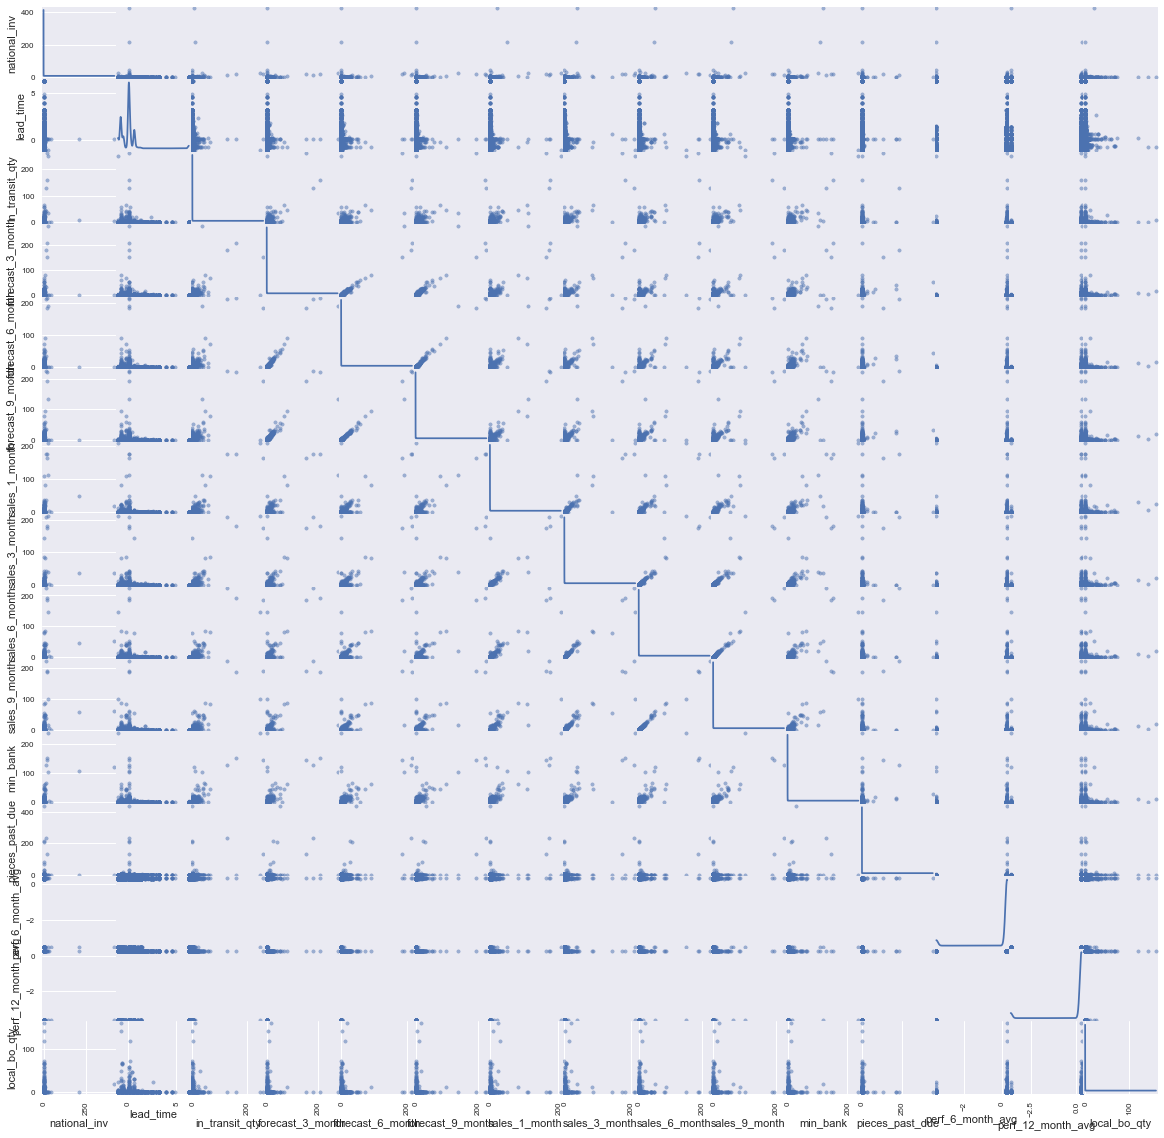

In [64]:
samples = pd.concat([std_data[labels == 0].sample(frac=0.1),std_data[labels ==1]])
display(pd.tools.plotting.scatter_matrix(samples[num_col], alpha=0.5, figsize=(12,12), diagonal='kde'))

In [65]:
kb = SelectKBest(k=10)
feat_data = kb.fit_transform(std_data,labels)
indices =  kb.get_support(indices=True)
feat_data = pd.DataFrame(feat_data, columns = data.columns[indices])
display(feat_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1693050 entries, 0 to 1693049
Data columns (total 10 columns):
lead_time            float64
in_transit_qty       float64
potential_issue      float64
pieces_past_due      float64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty         float64
deck_risk            float64
ppap_risk            float64
rev_stop             float64
dtypes: float64(10)
memory usage: 129.2 MB


None

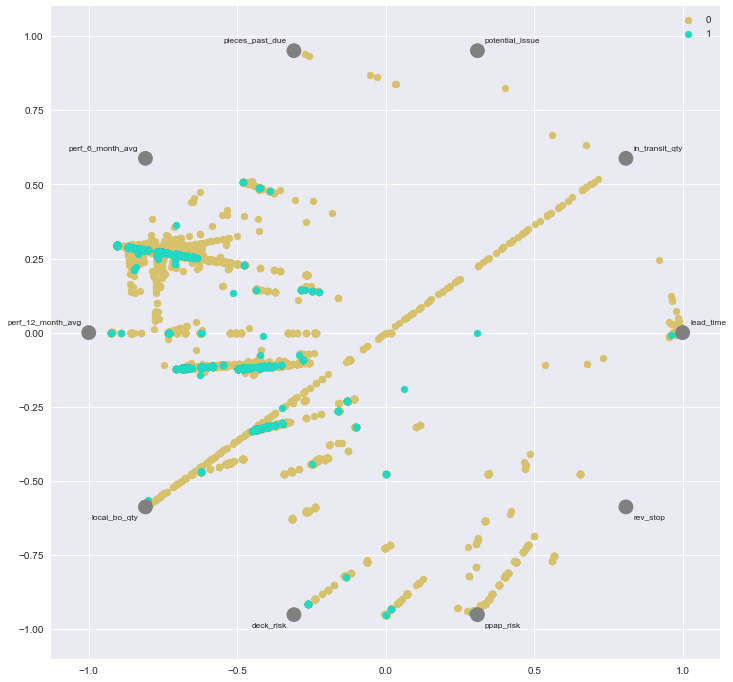

In [67]:
# Create a DataFrame of the chosen samples
plt.figure(figsize =(12,12))
samples = feat_data
samples['label'] = labels
display(pd.tools.plotting.radviz(samples, 'label'))

In [72]:
plt.figure(figsize =(12,12))
samples = std_data
samples['label'] = labels
samples_labels = samples.label
pd.tools.plotting.radviz(samples.sample(50000), 'label')

In [69]:
def vs_frontiers(good_data,good_lables):
    from scipy import stats
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.font_manager
    from sklearn import svm
    from sklearn.pipeline import Pipeline
    pca = PCA(n_components=2, random_state = 42)
    X_train = pca.fit_transform(good_data[good_lables == 0])
    X_test = pca.transform(good_data[good_lables == 0].sample(10634))
    X_outliers = pca.transform(good_data[good_lables == 1])
    outliers_fraction = 0.01
    
    # fit the model
    clf = IsolationForest(n_jobs = -1,random_state =42).fit(X_train)
    
    xmin, ymin = np.amin(X_train, axis=0)
    print  xmin, ymin
    xmax, ymax = np.amax(X_train, axis=0)
    print  xmax, ymax
    xmin, ymin ,xmax, ymax = xmin -100, ymin -100 ,xmax + 100, ymax +100
    
    xx, yy = np.meshgrid(np.linspace(xmin,xmax, 600), np.linspace(ymin,ymax, 600))
    
    #predict
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_outliers =clf.predict(X_outliers)
    n_error_train = y_pred_train[y_pred_train == -1].size
    n_error_test = y_pred_test[y_pred_test == -1].size
    n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

    # plot the line, the points, and the nearest vectors to the plane
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(12,12))
    plt.title("Novelty Detection")
    scores_pred = clf.decision_function(X_train)
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
    #threshold = -0.18
    print Z.min()
    print threshold
    print Z.max()
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.PuBu)
    a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='darkred')
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='palevioletred')
    s = 30
    b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s)
    b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
    c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
    plt.axis('tight')
    plt.xlim((xmin,xmax))
    plt.ylim((ymin,ymax))
    plt.legend([a.collections[0], b1, b2, c],
               ["learned frontier", "training observations",
                "new regular observations", "new abnormal observations"],
               loc="upper left",
               prop=matplotlib.font_manager.FontProperties(size=11))
    plt.xlabel(
        "error train: %d/168214 ; errors novel regular: %d/10634 ; "
        "errors novel abnormal: %d/10634"
        % (n_error_train, n_error_test, n_error_outliers))
    plt.show()

-4.95352162556 -5.07601798394
7.46678310767 226.229652283
-0.238294278205
-0.162657226099
0.0646289025712


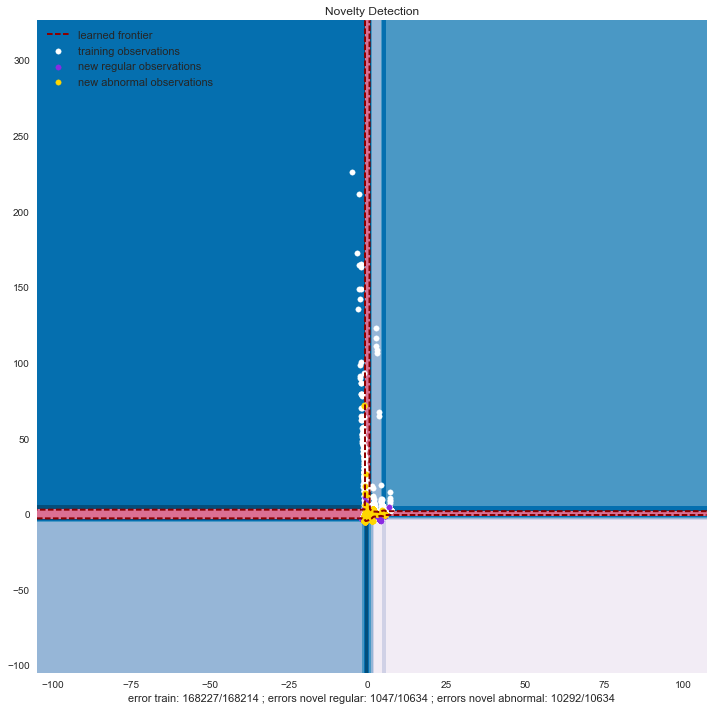

In [70]:
vs_frontiers(feat_data,labels)

-0.160217758211 -2.52116596553
614.083660484 14.1417247889
-0.291425022974
-0.162254996842
0.0867129369809


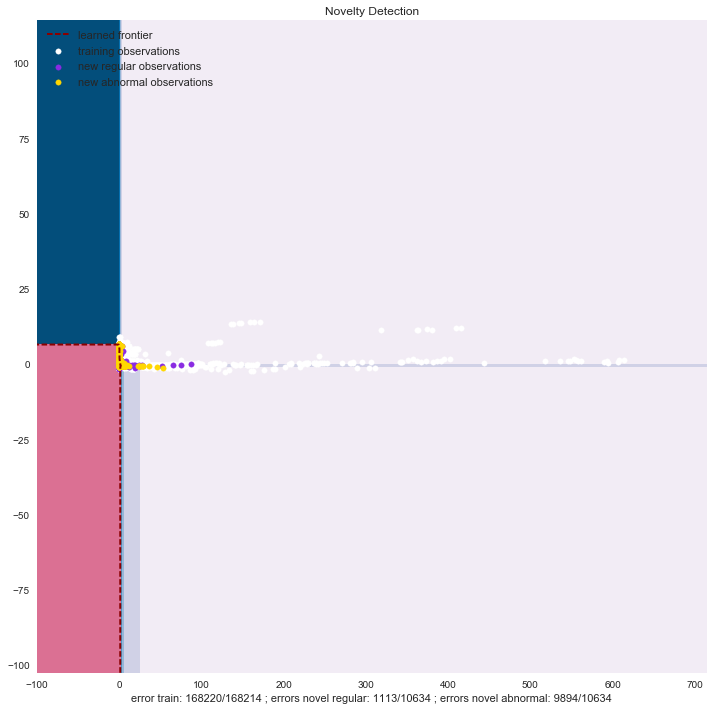

In [71]:
vs_frontiers(std_data,labels)

In [79]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.feature_selection import SelectKBest
from imblearn.metrics import sensitivity_score
from sklearn.svm import SVC
def fit_model(X, y):
    # This dataset is too high-dimensional. Better do PCA:
    pca = PCA()

    # Maybe some original features where good too?
    selection = SelectKBest(k=1)
    
    combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])
    svm = SVC(kernel="linear")
    #set the pipeline
    pipeline = Pipeline([("features", combined_features), ("svm", svm)])
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(10, test_size = 0.20, random_state = 42)

    #params dictionary for grid search
    param_grid = dict(features__pca__n_components=[1, 2, 3, 4, 5],
                  features__univ_select__k=[1, 2],
                  svm__C=[0.1, 1, 10])

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(sensitivity_score)

    # TODO: Create the grid search object
    grid = GridSearchCV(pipeline, param_grid,scoring = scoring_fnc,cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [ ]:
# Fit the training data to the model using grid search
clf = fit_model(samples, samples_labels)
print 'operation completed'

In [ ]:
display(clf.get_params())

In [ ]:
#save estimator
pickle.dump(clf), open('estimator.p', 'wb')

## loading testing data
now load the test data and test on the classifier.

In [ ]:
# Load the kepler dataset
Testdata = pd.read_csv(os.path.join("project_dataset", 'exoTest.csv'),index_col=0)
#    print "kepler dataset has {} samples with {} features each.".format(*data.shape)
#except:
#    print "Dataset could not be loaded. Is the dataset missing?"

In [ ]:
#create label array and drop it from features
testlabels = Testdata.LABEL
#labels = [1 if x == 2 else 0 for x in labels]
testlabels.replace(1,0, inplace=True)
testlabels.replace(2,1, inplace=True)
Testdata.drop('LABEL',axis=1, inplace =True)

## evaluation of the result

In [ ]:
X_test = pca.transform(Testdata)
y_pred = clf_C.predict(X_test)
print classification_report(testlabels, y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(100*cm/float(cm.sum()))
ax = sns.heatmap(df_cm.round(2), annot=True, cmap='Greys', fmt='g', linewidths=1)
ax.set_title("Confusion Matrix - per 100 predictions")
ax.set_xlabel('Predicted', fontsize=16)
ax.set_ylabel('True', fontsize=16, rotation=90)
plt.show()